## 2. Geometry of pores and throats
<img src="img/openpnm.jpeg"  width="800" height="800">

In [94]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

import openpnm as op

%matplotlib notebook

In [111]:
"""
Definitions
"""
# Params
SPACING = 0.0001 # meters
SHAPE = [100,100,1]

# Network topology
pn = op.network.Cubic(shape = SHAPE, spacing=SPACING)

# Network geometry
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts) # random, sensible sizes

# Fluids: water and methane (= air)
water = op.phases.Water(network=pn)
ch4 = op.phases.Air(network=pn)



In [112]:
"""
Water percolation
"""
# Washburn equation
water.add_model(propname = 'throat.entry_pressure',
                model = op.models.physics.capillary_pressure.washburn)

o_perco = op.algorithms.OrdinaryPercolation(network = pn)
o_perco.setup(phase = water, access_limited = True)
o_perco.set_inlets(pores = pn.pores('back')) # where water will entry from
o_perco.set_outlets(pores = pn.pores('front')) # where water will exit

o_perco.run()


―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.OrdinaryPercolation.set_inlets 
    TIME STAMP: 2019-10-30 15:11:41,145    


Percolating threshold at 5274.408729472492 units of pressure


<IPython.core.display.Javascript object>


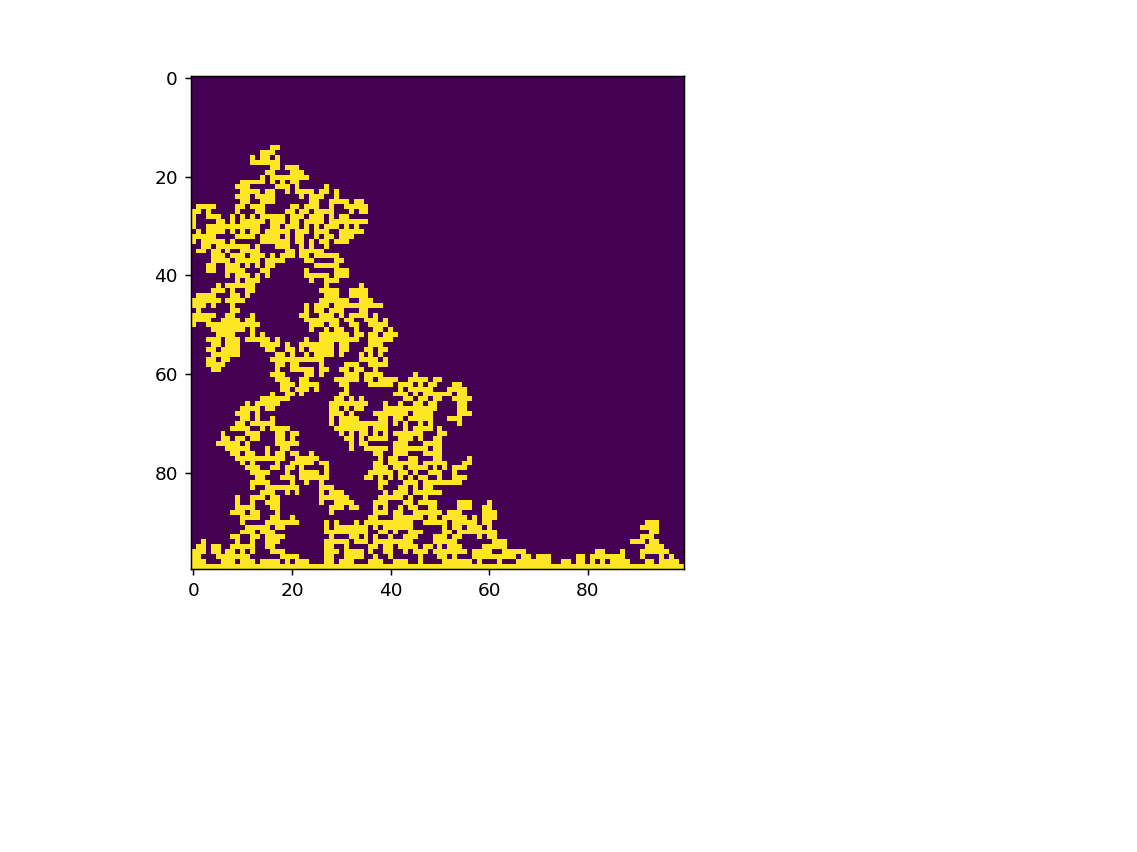

In [116]:
# Gather results
percolating_threshold = o_perco.get_percolation_threshold()
print("Percolating threshold at", percolating_threshold, "units of pressure")

PRESSURE = percolating_threshold - 100
water.update(o_perco.results(Pc = PRESSURE))

# Plot
plt.figure()
plt.imshow(sp.reshape(water['pore.occupancy'], newshape=SHAPE[:-1]))
plt.show()

In [117]:
"""
Fickian diffusion
"""
# Compute conductance
ch4.add_model(propname = 'throat.diffusive_conductance',
                  model = op.models.physics.diffusive_conductance.ordinary_diffusion)

# Restriction: waterlogged pores 
ch4['throat.conductance'] = ch4['throat.diffusive_conductance'] * (o_perco['throat.invasion_pressure'] > PRESSURE)

fick_diffusion = op.algorithms.TransientFickianDiffusion(network = pn)
fick_diffusion.setup(phase = ch4, conductance = 'throat.conductance')

# BC and IC
# pores potentially producing CH4 are waterlogged
waterlogged_pores = pn.pores()[water['pore.occupancy']==1]
pores_producing_ch4 = waterlogged_pores
pores_producing_ch4 = np.unique(pores_producing_ch4) # take out duplicated

FRAC_CH4_TOP = 0.0; FRAC_CH4_BOTTOM = 1.0
fick_diffusion.set_value_BC(pores = pn.pores('front'), values = FRAC_CH4_TOP)
fick_diffusion.set_value_BC(pores = pores_producing_ch4, values = FRAC_CH4_BOTTOM)
fick_diffusion.set_IC(0.0)

# time-related parameters
fick_diffusion.setup(t_scheme = 'cranknicolson', t_final = 100, t_output = 0.01, t_step = 0.01, t_tolerance = 1e-12)


fick_diffusion.run()
print(fick_diffusion)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientFickianDiffusion : alg_02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc_rate                                      0 / 10000
2     pore.bc_value                                  1916 / 10000
3     pore.concentration                            10000 / 10000
4     pore.concentration@0                          10000 / 10000
5     pore.concentration@11e-2                      10000 / 10000
6     pore.concentration@12e-2                      10000 / 10000
7     pore.concentration@13e-2                      10000 / 10000
8     pore.concentration@14e-2                      10000 / 10000
9     pore.concentration@15e-2                      10000 / 10000
10    pore.concentration@16e-2                    

<IPython.core.display.Javascript object>


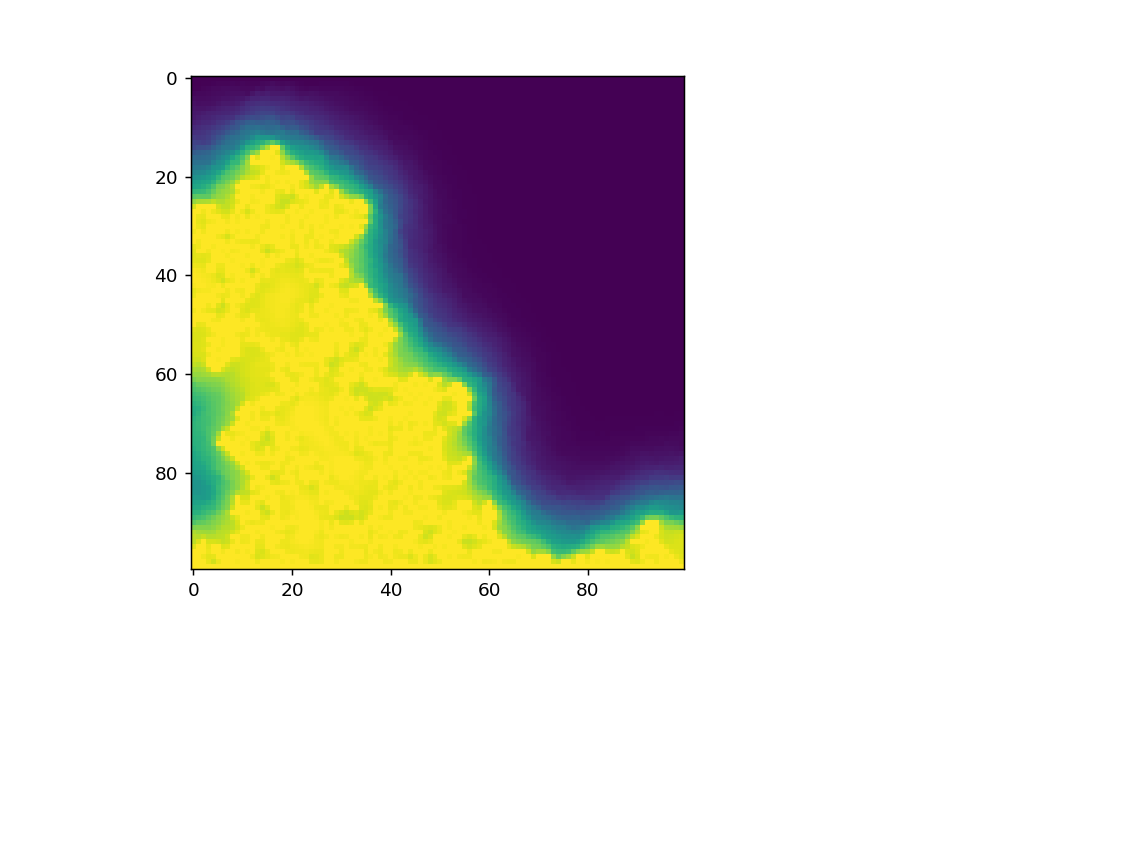

In [118]:
"""Animation of Transport Fickian using matplotlib"""
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for i in range(1,9,2):
    im = plt.imshow(fick_diffusion['pore.concentration@' + str(i) + 'e-2'].reshape(SHAPE[:-1]), 
                    animated=True, vmin = 0, vmax = 1)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=2000, blit=False, repeat_delay=1000)

plt.show()


ani.save(filename = 'diff_movie.mp4')

----
## End of Wrong Model #2
----
----
# End of talk. Kiitos!